## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import seaborn as sns
import time
from datetime import timedelta
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.index.min()


Timestamp('2018-03-01 00:00:00')

In [6]:
df.index.max()

Timestamp('2018-08-31 23:50:00')

В данном датасете мы наблюдаем 26496 объектов и 1 признак. При загрузке датасета мы сразу перевели дату в формат DateTime и поместили его в индекс. Наш датасет представлей за период с 2018-03-01 по 2018-08-31. Целевой признак-"num_orders" - количество заказов.

Далее проведем ресемплирование временного ряда, отсортировав и сгруппировав по часам, а также рассчитав сумму заказов для каждого часа

In [7]:
df.sort_index(inplace=True)
df=df['2018-03':'2018-08'].resample('1H').sum()

In [8]:
df.head()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# 2. Анализ

Посмотрим на распределение заказов в разрезе дней и месяцев

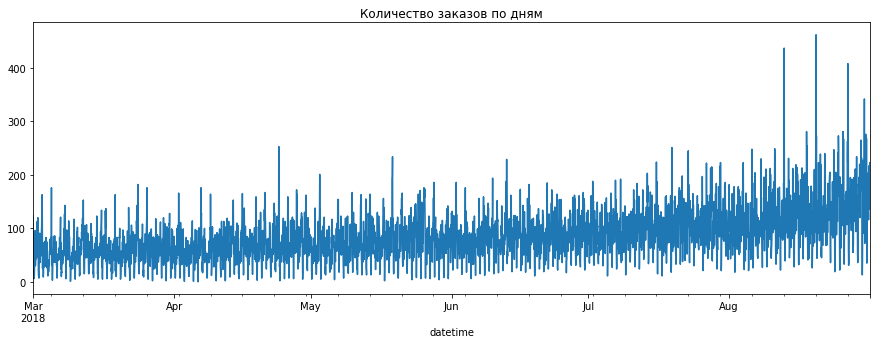

In [9]:
plt.figure(figsize=(15,5))
plt.title('Количество заказов по дням')
df['num_orders'].plot();

Мы видим, что временной ряд не стационарен, так как его статистические свойства со временем изменяются, в частности среднее значение и дисперсия изменяются со временем.

Чтобы в нашем временном ряду снизить колебания, применим скользящее среднее.

 Создадим столбец со скользящим средним и окном 10.

In [10]:
df['rolling_mean']=df['num_orders'].rolling(window=10).mean()
df=df.fillna(0)

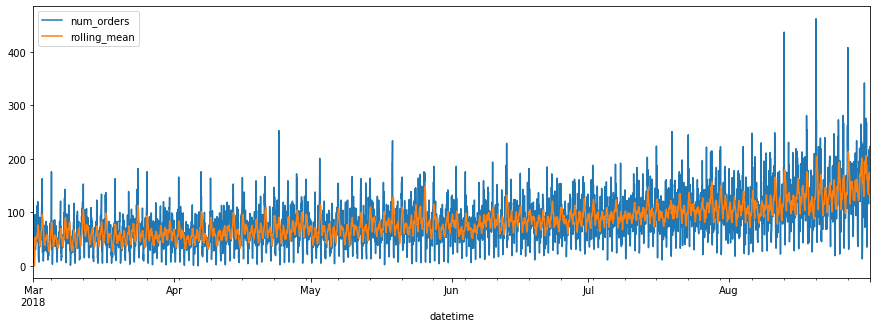

In [11]:
df.plot(figsize = (15,5));

Произведем декомпозицию временного ряда, чтобы увидеть тренд, сезонность и остаток декомпозиции, то есть шум.

In [12]:
decomposed = seasonal_decompose(df['num_orders'])

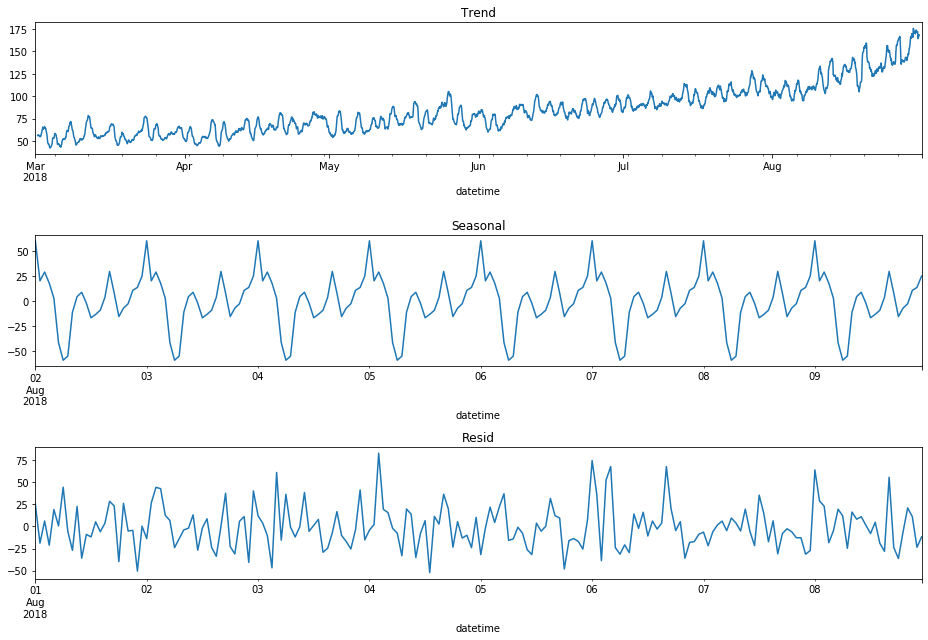

In [13]:
plt.figure(figsize=(13, 9))
plt.subplot(311)

decomposed.trend['2018-03-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)

decomposed.seasonal['2018-08-02':'2018-08-09'].plot(ax=plt.gca())
plt.title('Seasonal')

plt.subplot(313)

decomposed.resid['2018-08-01':'2018-08-08'].plot(ax=plt.gca())
plt.title('Resid')
plt.tight_layout()

В тренде выделен весь доступный для анализа отрезок. Можем видеть, как изменяется количество заказов в течении всего анализиуремого периода.  По сезонности можно видеть, как изменяется количество заказов в течении дня и наблюдать повторяемость этого процесса в последующие дни в рамках 1 недели.Белый шум наблюдаем с средним отклонением в райне 0.

Для дальнейшего анализа сделаем копию нашего датасета.

In [14]:
df_copy = df.copy()

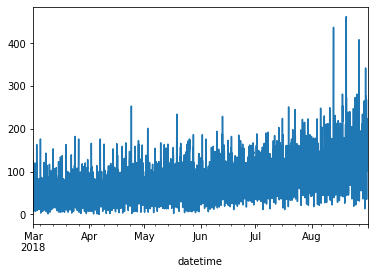

In [15]:
df_copy['num_orders'].plot();

# 3. Обучение

Подготовим функцию для создания календарных признаков и отстающих значений

In [16]:
def make_features(df_copy, max_lag, rolling_mean_size):
  
    df_copy['year']=df_copy.index.year
    df_copy['month']=df_copy.index.month
    df_copy['day']=df_copy.index.day
    df_copy['day_of_week']=df_copy.index.dayofweek
    
    for i in range(1,max_lag+1):
        df_copy['lag_{}'.format(i)]=df_copy['num_orders'].shift(i)
    df_copy['rolling_mean']=df_copy['num_orders'].shift().rolling(window=rolling_mean_size).mean()
    return df_copy

Создали следующие признаки:

день недели. День недели  существенно может оказать влияние на показатель загруженности трафика, потому что, например, зугруженность в будние и выходные дни отличается.

час. Данный признак дает информацию о загруженности на определенный период в течение дня

lag. Показывает, будут ли данные расти

rolling. Задаёт общий тренд временного ряда

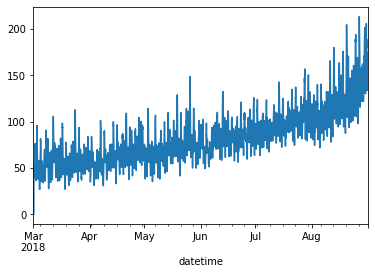

In [17]:
df_copy['rolling_mean'].plot();

**model LinearRegression¶**

In [18]:
df_copy = df_copy.dropna()

подберем лучшие значения lag и rolling_mean

In [19]:
best_rmse={}

for i in range(1,30):
    for j in range(1,30):
        df_copy=make_features(df_copy,i,j)
        train, valid = train_test_split(df_copy, shuffle=False, test_size = 0.2)
        train = train.dropna()
        features_train = train.drop(['num_orders'], axis=1)
        target_train = train['num_orders']
        features_valid = valid.drop(['num_orders'], axis=1)
        target_valid = valid['num_orders']
        model = LinearRegression().fit(features_train,target_train)
        predict = model.predict(features_valid)
        RMSE_line=np.sqrt(mean_squared_error(predict,target_valid))
        best_rmse[RMSE_line] = [i,j]
print('-'*10)
print('Лучшее значение')
print(f'lag->{best_rmse[min(best_rmse.keys())][0]}, rolling_mean->{best_rmse[min(best_rmse.keys())][1]}, RMSE->{min(best_rmse.keys())}')

----------
Лучшее значение
lag->22, rolling_mean->24, RMSE->40.17424029257082


In [20]:
df_copy=make_features(df_copy,22,24)

In [21]:
df_copy = df_copy.dropna()

<div class="alert alert-block alert-warning">
<b>Разделим датасет на обучающую, валидационную(20%) и тестовую выборки (10%)</b> 
</div>

In [22]:
train, valid = train_test_split(df_copy,shuffle=False, test_size=0.2, random_state=12345)
valid, test = train_test_split(valid, shuffle=False, test_size=0.5, random_state=12345)
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [23]:
%%time
start_time = time.monotonic()
model_lr = LinearRegression().fit(features_train,target_train)
predict_lr = model_lr.predict(features_valid)
RMSE_line=np.sqrt(mean_squared_error(predict_lr,target_valid))
print(f'Лучший показатель RMSE модели LinearRegression->{RMSE_line}')
end_time = time.monotonic()
time_line= timedelta(seconds=end_time - start_time)

Лучший показатель RMSE модели LinearRegression->34.194269890740806
CPU times: user 32.5 ms, sys: 32.4 ms, total: 64.9 ms
Wall time: 12.9 ms


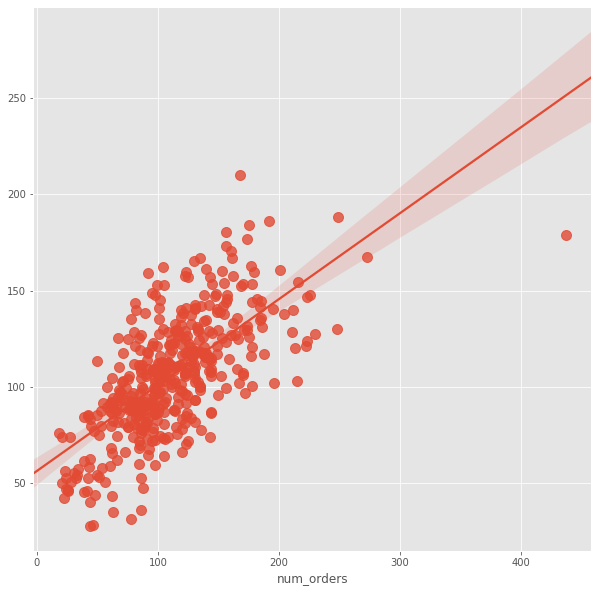

In [24]:
plt.style.use('ggplot') 
plt.figure( figsize= (10 , 10 )) 
sns.regplot(target_valid,  predict_lr,  fit_reg= True,  scatter_kws= {"s":  100 });

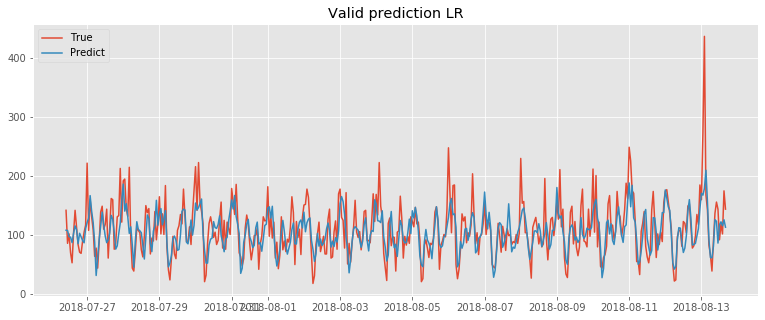

In [25]:
plt.figure(figsize=(13, 5))

plt.plot(target_valid, label='True')
plt.plot(target_valid.index, predict_lr, label='Predict')

plt.title('Valid prediction LR')
plt.legend()
plt.show()

**model RandomForestRegressor¶**

Подберем лучшие значениея max_depth и n_estimators.

Подбираяю лучший гиперпараметр max_depth

In [26]:
%%time
best_depth = 0
best_result = 48
for max_depth in range(1,30):
    model=RandomForestRegressor(max_depth=max_depth,random_state=12345)
    model.fit(features_train,target_train)
    predict=model.predict(features_valid)
    result = np.sqrt(mean_squared_error(predict,target_valid))
    print(f"depth = {max_depth}:\t{result}")
    if result < best_result:
        best_depth = max_depth
        best_result = result
print('Лучшая глубина дерева:', best_depth,'Лучший показатель RMSE:', best_result)               

depth = 1:	49.66829944644731
depth = 2:	44.458705008204554
depth = 3:	42.66717668012194
depth = 4:	40.820888915315166
depth = 5:	38.764424701890945
depth = 6:	37.44436339383224
depth = 7:	36.18980957078327
depth = 8:	35.22942210284453
depth = 9:	35.43696737018361
depth = 10:	35.127671516905416
depth = 11:	34.59897300512069
depth = 12:	34.87963893928329
depth = 13:	34.40570719418595
depth = 14:	34.82597034279287
depth = 15:	34.48495073385237
depth = 16:	34.43027622094175
depth = 17:	34.52342806542891
depth = 18:	35.04226891327574
depth = 19:	34.6482151408796
depth = 20:	34.335342560889394
depth = 21:	34.74479347136514
depth = 22:	34.11339974194083
depth = 23:	34.25229053956849
depth = 24:	34.57466896076791
depth = 25:	34.608797520737916
depth = 26:	34.23604881881631
depth = 27:	34.62327650044726
depth = 28:	34.5874113009508
depth = 29:	34.63818320528804
Лучшая глубина дерева: 22 Лучший показатель RMSE: 34.11339974194083
CPU times: user 15.2 s, sys: 0 ns, total: 15.2 s
Wall time: 15.6 s


In [27]:
%%time
best_estim = 0
best_result_e = 48
for estim in range(1,201):
    model=RandomForestRegressor(n_estimators=estim,max_depth=22,random_state=12345)
    model.fit(features_train,target_train)
    predict_forest=model.predict(features_valid)
    result = np.sqrt(mean_squared_error(predict_forest,target_valid))
    print(f"n_estimator = {estim}:\t{result}")
    if result < best_result_e:
        best_estim = estim
        best_result_e = result
print('Лучшее количество деревьев:', best_estim,'Лучший показатель RMSE:', best_result_e)               

n_estimator = 1:	50.66748091101314
n_estimator = 2:	39.69465643302145
n_estimator = 3:	37.59912816130107
n_estimator = 4:	36.936193972169185
n_estimator = 5:	35.98410188319005
n_estimator = 6:	35.142342523835616
n_estimator = 7:	34.595055532360455
n_estimator = 8:	34.54685341614274
n_estimator = 9:	34.37186273072377
n_estimator = 10:	34.11339974194083
n_estimator = 11:	34.04552554572122
n_estimator = 12:	33.83459099170876
n_estimator = 13:	33.71496730069532
n_estimator = 14:	33.72362660571321
n_estimator = 15:	33.768866502643455
n_estimator = 16:	33.762373043682366
n_estimator = 17:	33.88796801747251
n_estimator = 18:	33.90063355593586
n_estimator = 19:	33.7581907374742
n_estimator = 20:	33.87249045932464
n_estimator = 21:	33.8368660255782
n_estimator = 22:	33.736308450178434
n_estimator = 23:	33.737698744912
n_estimator = 24:	33.698038369425234
n_estimator = 25:	33.828144450088345
n_estimator = 26:	33.87683595238655
n_estimator = 27:	33.86203062715851
n_estimator = 28:	33.764190628062

теперь проверим результат на валидационной выборке с учетом подобранных гиперпараметров

In [28]:
%%time
start_time = time.monotonic()
best_model_forest=RandomForestRegressor(n_estimators=197,max_depth=22, random_state=12345)
best_model_forest.fit(features_train,target_train)
predict_f=best_model_forest.predict(features_valid)
rmse_forest = np.sqrt(mean_squared_error(predict_f,target_valid))
print(f'Лучший показатель RMSE модели RandomForestRegressor->{rmse_forest}')
end_time = time.monotonic()
time_forest= timedelta(seconds=end_time - start_time)

Лучший показатель RMSE модели RandomForestRegressor->42.8425527841349
CPU times: user 36.9 ms, sys: 0 ns, total: 36.9 ms
Wall time: 35 ms


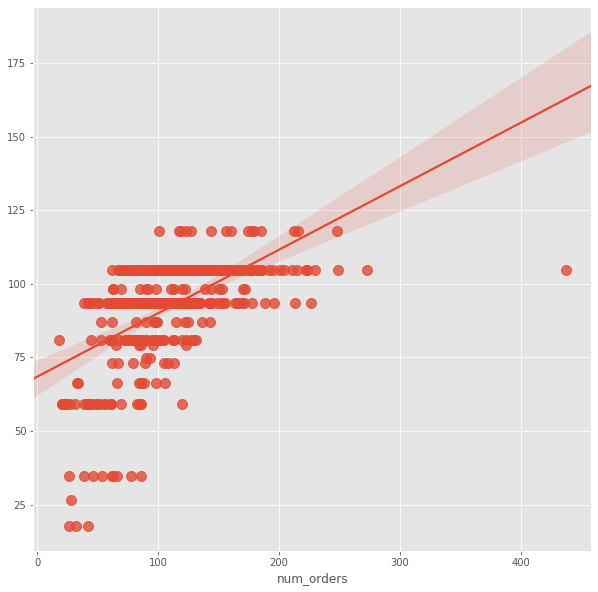

In [29]:
plt.style.use('ggplot') 
plt.figure( figsize= (10 , 10 )) 
sns.regplot(target_valid,  predict_f,  fit_reg= True,  scatter_kws= {"s":  100 });

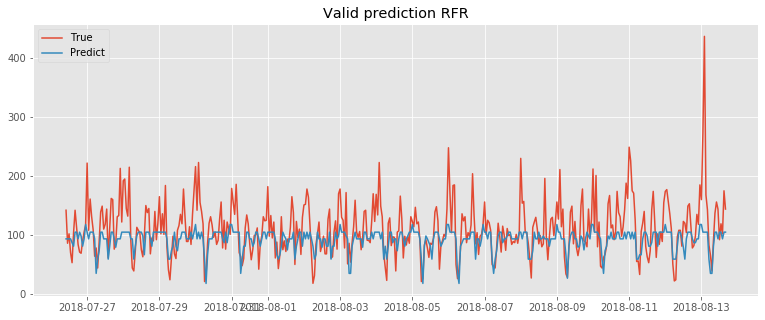

In [30]:
plt.figure(figsize=(13, 5))

plt.plot(target_valid, label='True')
plt.plot(target_valid.index, predict_f, label='Predict')

plt.title('Valid prediction RFR')
plt.legend()
plt.show()

**CatBoostRegressor**

In [31]:

the_best_cat = {}
for i in range(100,800,100):
    for j in range(1,12,2):
        model_cat=CatBoostRegressor(depth=j,iterations=i,learning_rate=0.1,loss_function='RMSE').fit(features_train,target_train,verbose=100)
        predict_c=model_cat.predict(features_valid)
        rmse=mean_squared_error(predict_c,target_valid)
        the_best_cat[np.sqrt(rmse)] = [j, i]
print('-'*10)
print('Лучшее значение')
print(f'depth->{the_best_cat[min(the_best_cat.keys())][0]}, iterations->{the_best_cat[min(the_best_cat.keys())][1]}, RMSE->{min(the_best_cat.keys())}')        


0:	learn: 34.8196828	total: 47.7ms	remaining: 4.72s
99:	learn: 24.0167256	total: 659ms	remaining: 0us
0:	learn: 34.3119611	total: 4.93ms	remaining: 488ms
99:	learn: 21.6188042	total: 1.97s	remaining: 0us
0:	learn: 34.1906117	total: 3.55ms	remaining: 352ms
99:	learn: 19.6298962	total: 2.11s	remaining: 0us
0:	learn: 34.1870571	total: 8.1ms	remaining: 802ms
99:	learn: 17.4265741	total: 4s	remaining: 0us
0:	learn: 34.1829864	total: 49.7ms	remaining: 4.92s
99:	learn: 14.2068657	total: 10.1s	remaining: 0us
0:	learn: 34.2203460	total: 353ms	remaining: 34.9s
99:	learn: 10.8187947	total: 32.3s	remaining: 0us
0:	learn: 34.8196828	total: 1.01ms	remaining: 201ms
100:	learn: 24.0049260	total: 604ms	remaining: 592ms
199:	learn: 23.2634756	total: 1.29s	remaining: 0us
0:	learn: 34.3119611	total: 1.56ms	remaining: 310ms
100:	learn: 21.5939022	total: 1.21s	remaining: 1.19s
199:	learn: 19.9110536	total: 2.48s	remaining: 0us
0:	learn: 34.1906117	total: 2.65ms	remaining: 528ms
100:	learn: 19.5988644	total:

проверим результатат на влидационной выборке с учетом полученных гиперпараметров

0:	learn: 34.1906117	total: 5.71ms	remaining: 2.28s
100:	learn: 19.5988644	total: 3.15s	remaining: 9.32s
200:	learn: 16.8126135	total: 6.61s	remaining: 6.54s
300:	learn: 14.7671062	total: 9.87s	remaining: 3.25s
399:	learn: 13.2433949	total: 13.3s	remaining: 0us
RMSE:  32.6425530548877
Время выполнения: 0:00:14.551188
CPU times: user 12.1 s, sys: 1.75 s, total: 13.9 s
Wall time: 14.9 s


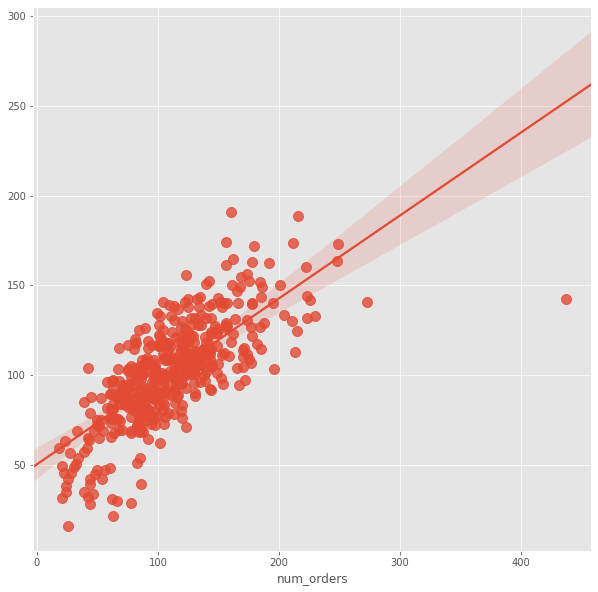

In [32]:
%%time
start_time = time.monotonic()

plt.style.use('ggplot') 
best_model_cat=CatBoostRegressor(depth=5,
                        iterations=400,
                        learning_rate=0.1,
                        loss_function='RMSE').fit(features_train,target_train,verbose=100)
predict_c=best_model_cat.predict(features_valid)
rmse_CAT=mean_squared_error(predict_c,target_valid)
end_time = time.monotonic()
time_cat= timedelta(seconds=end_time - start_time)
print('RMSE: ',np.sqrt(rmse_CAT))
print ("Время выполнения:", time_cat)
result_cat = np.sqrt(rmse_CAT)
plt.figure( figsize= (10 , 10 )) 
sns.regplot(target_valid,  predict_c,  fit_reg= True,  scatter_kws= {"s":  100 });

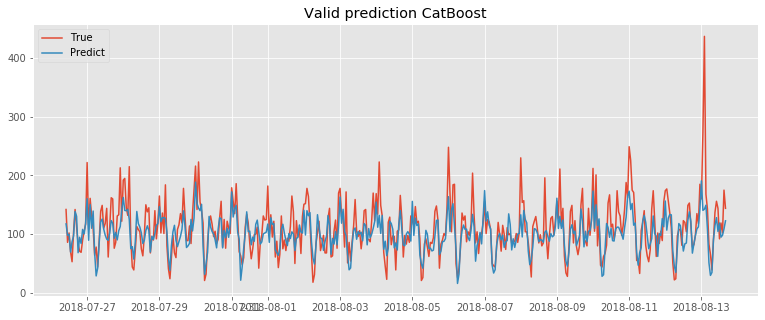

In [33]:
plt.figure(figsize=(13, 5))

plt.plot(target_valid, label='True')
plt.plot(target_valid.index, predict_c, label='Predict')

plt.title('Valid prediction CatBoost')
plt.legend()
plt.show()

# 4. Тестирование

Проверим работу наших моделей на тестовых наборах данных

<div class="alert alert-block alert-warning">
<b> объединим обучающую и валидационную выборки</b> 
</div>

In [34]:
train_new = pd.concat([train, valid], sort = False, axis = 0)
features_train_new = train_new.drop(['num_orders'], axis=1)
target_train_new = train_new['num_orders']

In [35]:
%%time
start_time = time.monotonic()
model_lr_test = LinearRegression().fit(features_train_new,target_train_new)
predict_lr_test = model_lr_test.predict(features_test)
RMSE_line_test=np.sqrt(mean_squared_error(predict_lr_test,target_test))
print(f'Лучший показатель RMSE модели LinearRegression->{RMSE_line_test}')
end_time = time.monotonic()
time_line_test= timedelta(seconds=end_time - start_time)
result_lr = RMSE_line_test

Лучший показатель RMSE модели LinearRegression->46.8292398691731
CPU times: user 44.3 ms, sys: 30.5 ms, total: 74.8 ms
Wall time: 50.8 ms


In [36]:
%%time
start_time = time.monotonic()
model_forest_test=RandomForestRegressor(n_estimators=197,max_depth=22, random_state=12345)
model_forest_test.fit(features_train_new,target_train_new)
predict_f_test=model_forest_test.predict(features_test)
rmse_forest_test = np.sqrt(mean_squared_error(predict_f_test,target_test))
print(f'Лучший показатель RMSE модели RandomForestRegressor->{rmse_forest_test}')
end_time = time.monotonic()
time_forest_test= timedelta(seconds=end_time - start_time)
result_forest_test = rmse_forest_test

Лучший показатель RMSE модели RandomForestRegressor->43.77809095135194
CPU times: user 15.6 s, sys: 9.84 ms, total: 15.6 s
Wall time: 16 s


In [37]:
%%time
start_time = time.monotonic()

plt.style.use('ggplot') 
model_cat_test=CatBoostRegressor(depth=5,
                        iterations=400,
                        learning_rate=0.1,
                        loss_function='RMSE').fit(features_train_new,target_train_new,verbose=100)
predict_c_test=model_cat_test.predict(features_test)
rmse_CAT_test=mean_squared_error(predict_c_test,target_test)
end_time = time.monotonic()
time_cat_test= timedelta(seconds=end_time - start_time)
print('RMSE: ',np.sqrt(rmse_CAT_test))
print ("Время выполнения:", time_cat)
result_cat_test = np.sqrt(rmse_CAT_test)

0:	learn: 37.0690976	total: 6.53ms	remaining: 2.6s
100:	learn: 21.2147292	total: 3.41s	remaining: 10.1s
200:	learn: 18.1007167	total: 7.05s	remaining: 6.98s
300:	learn: 16.0356861	total: 10.5s	remaining: 3.46s
399:	learn: 14.2895672	total: 14.1s	remaining: 0us
RMSE:  40.43201912817793
Время выполнения: 0:00:14.551188
CPU times: user 12.8 s, sys: 1.6 s, total: 14.4 s
Wall time: 15.4 s


In [38]:
resume={'model':["LR","RandomForestRegressor","CatBoost"],'RMSE':[result_lr,result_forest_test,result_cat_test]
        ,'time':[time_line_test, time_forest_test, time_cat_test]}
df_resume = pd.DataFrame(resume)
df_resume

,model,RMSE,time
0,LR,46.829240,00:00:00.050756
1,RandomForestRegressor,43.778091,00:00:15.962357
2,CatBoost,40.432019,00:00:15.380565


# Вывод

По всем трем моделям получен показатель RMSE ниже 48. Можно отметить, что Линейная Регрессия  показала себя хуже всего, за исключением времени расчета, модель бустинга показала наилучший результат, по времени расчета сопаставимый со случайным лесом.